# 02-10 Portfolio Optimization and The Efficient Frontier

given:
- set of equities
- target return

find
- allocation to each equity that minimizes risk

### what is risk?

standard deviation of historical daily returns, can plot return vs risk

### Visualize return vs risk

risk x-axis, return y-axis, want low x value, high y value

Harry Markowitz - discovered mean variance optimization, i.e., can get portfolio with lower risk and higher return

### Why covariance matters

find stocks that zig when others zag and build portfolio of those to make smoother returns

### Mean Variance Optimization (MVO)

Inputs
- Expected return
- Volatility
- Covariance (matrix between each asset and other asset, correlation between returns)
- Target return

Output
- Asset weights for portfolio that minimizes risk


In [8]:
# Simulations

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [7]:
n_assets = 4
n_obs = 1000
return_vec = np.random.randn(n_assets, n_obs)

In [18]:
return_vec.T

array([[-0.47127552,  0.3187635 ,  0.22690673,  1.11784894],
       [ 1.08407243,  1.51110387, -2.39855358, -0.00572655],
       [-0.37922328, -1.13662678, -0.44785801,  1.51839373],
       ..., 
       [-1.85971515,  1.32491703,  0.87511309, -1.60703467],
       [ 0.91382219, -0.45076279,  0.45349999, -0.39076092],
       [-1.35383977,  0.24077279, -1.56310501,  1.14432029]])

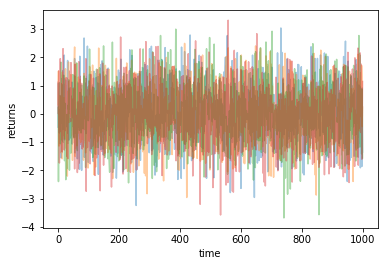

In [19]:
plt.plot(return_vec.T, alpha=.4)
plt.xlabel("time")
plt.ylabel("returns")
plt.show()

In [21]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print (rand_weights(n_assets))
print (rand_weights(n_assets))

[ 0.32231402  0.09189738  0.34712795  0.23866065]
[ 0.38245143  0.17489763  0.18194366  0.26070729]


In [22]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

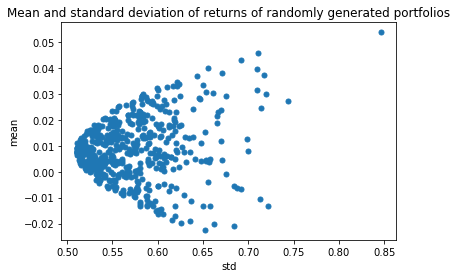

In [29]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.show()

In [9]:
## Taken from Quantopian, this thing blows... wtf, gets a horrible Sharpe ratio, WTF?

def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks



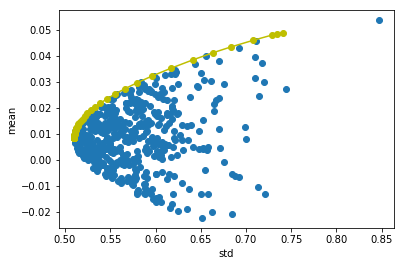

In [33]:
weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.show()

In [2]:
from DataHelper import DataHelper

In [6]:
symbols = ['IBM', 'GLD', 'YHOO', 'GOOG']
start_date = '2008-01-01'
end_date = '2012-01-01'
priceHistory = DataHelper.GetPriceHistory(symbols, start_date, end_date, False)
normed = DataHelper.normalize_data(priceHistory)
daily_returns = DataHelper.compute_daily_returns(normed)

In [17]:
weights, returns, risks = optimal_portfolio(daily_returns.values[1:,].T)

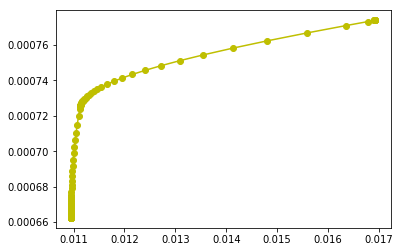

array([[  9.99554468e-01],
       [  4.41525562e-04],
       [  1.85413385e-06],
       [  2.15269875e-06]])

In [18]:
plt.plot(risks, returns, 'y-o')
plt.show()

weights

In [4]:
DataHelper.optimize_portfolio(start_date, end_date, symbols)


[ 0.25  0.25  0.25  0.25] (1009, 4)
[ 0.25  0.25  0.25  0.25] (1009, 4)
[ 0.25000001  0.25        0.25        0.25      ] (1009, 4)
[ 0.25        0.25000001  0.25        0.25      ] (1009, 4)
[ 0.25        0.25        0.25000001  0.25      ] (1009, 4)
[ 0.25        0.25        0.25        0.25000001] (1009, 4)
[  4.51936141e-01   5.48063859e-01   0.00000000e+00   2.77555756e-17] (1009, 4)
[  4.51936141e-01   5.48063859e-01   0.00000000e+00   2.77555756e-17] (1009, 4)
[  4.51936156e-01   5.48063859e-01   0.00000000e+00   2.77555756e-17] (1009, 4)
[  4.51936141e-01   5.48063874e-01   0.00000000e+00   2.77555756e-17] (1009, 4)
[  4.51936141e-01   5.48063859e-01   1.49011612e-08   2.77555756e-17] (1009, 4)
[  4.51936141e-01   5.48063859e-01   0.00000000e+00   1.49011612e-08] (1009, 4)
[  4.73221211e-01   5.26778789e-01   9.02056208e-17   0.00000000e+00] (1009, 4)
[  4.73221211e-01   5.26778789e-01   9.02056208e-17   0.00000000e+00] (1009, 4)
[  4.73221226e-01   5.26778789e-01   9.02056208e

{'SPY_stats': {'cum_ret': -0.059326522890654543,
  'daily_ret': 0.00010122561385951501,
  'sharpe_ratio': 0.08917910094782423,
  'std_ret': 0.01801887198249428},
 'cum_ret': 0.836757761320301,
 'daily_ret': 0.0006642709308416127,
 'optimal_allocs': array([  4.65482811e-01,   5.34517189e-01,   0.00000000e+00,
          1.21430643e-17]),
 'sharpe_ratio': 0.9553574346281178,
 'std_ret': 0.011037726545941928}

In [19]:
weights

array([[  9.99554468e-01],
       [  4.41525562e-04],
       [  1.85413385e-06],
       [  2.15269875e-06]])

In [28]:
# above method blows, using spo.minimize with sharpe ratio is best
DataHelper.get_stats(normed, weights[0])

({'cum_ret': 0.32574169831736555,
  'daily_ret': 0.00036580272413010395,
  'sharpe_ratio': 0.4422123853013884,
  'std_ret': 0.013131559437874243},
 2008-01-02    3.998218
 2008-01-03    4.013921
 2008-01-04    3.902679
 2008-01-07    3.877682
 2008-01-08    3.828210
 2008-01-09    3.861649
 2008-01-10    3.952096
 2008-01-11    3.891433
 2008-01-14    3.989999
 2008-01-15    3.904361
 2008-01-16    3.815081
 2008-01-17    3.754858
 2008-01-18    3.768302
 2008-01-22    3.694379
 2008-01-23    3.691857
 2008-01-24    3.833880
 2008-01-25    3.812436
 2008-01-28    3.769799
 2008-01-29    3.766740
 2008-01-30    3.695644
 2008-01-31    3.730664
 2008-02-01    4.042415
 2008-02-04    4.038725
 2008-02-05    3.996077
 2008-02-06    3.976457
 2008-02-07    3.999530
 2008-02-08    4.045885
 2008-02-11    4.102409
 2008-02-12    4.075143
 2008-02-13    4.131707
                 ...   
 2011-11-17    5.398525
 2011-11-18    5.392607
 2011-11-21    5.268735
 2011-11-22    5.286074
 2011-11-23  